In [30]:
import requests
import polyline

import matplotlib.pyplot as plt
import contextily as ctx

import xml.dom.minidom
from xml.etree.ElementTree import Element, SubElement, tostring

In [31]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_route(points):
    points = ';'.join(map(osrm_format, points))
    params = {
        'geometries': 'polyline6',
        'overview': 'full',
    }
    
    response = requests.get(f"http://127.0.0.1:8000/route/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    geometry = routes['routes'][0]['geometry']
    return (
        polyline.decode(geometry, 6), 
        routes['routes'][0]['distance'], 
        routes['routes'][0]['duration'],
    )

def plot_route(route):
    fig, ax = plt.subplots(1, 1, figsize=(12, 30))
    
    latitudes = [point[0] for point in route]
    longitudes = [point[1] for point in route]
    
    ax.plot(longitudes, latitudes, color='red', label='Route')
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    plt.show()

def format_distance(distance):
    distance = round(distance / 1000, 1)
    return f"{distance}km"

def format_duration(duration):
    duration = round(duration / 3600, 1)
    return f"{duration}h"

def create_gpx(route, output_file):
    gpx = Element('gpx', {
      'creator': 'Evgeny Arbatov',
      'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
      'xsi:schemaLocation': 'http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd',
      'version': '1.1',
      'xmlns': 'http://www.topografix.com/GPX/1/1'
    })
    
    trk = SubElement(gpx, "trk")
    trkseg = SubElement(trk, "trkseg")

    for lat, lng in route:
        SubElement(trkseg, "trkpt", attrib={"lat": str(lat), "lon": str(lng)})

    with open(output_file, "w") as f:
        gpx = xml.dom.minidom.parseString(
            tostring(gpx, encoding="unicode")
        ).toprettyxml()
        
        f.write(gpx)

def make_route(start, stop, output_file):
    points = [start] + [stop]

    osrm_route, distance, duration = get_route(points) 
    
    print(
        format_distance(distance),
        format_duration(duration),
    )
    
    plot_route(osrm_route)
    
    create_gpx(osrm_route, output_file)

10.7km 2.2h


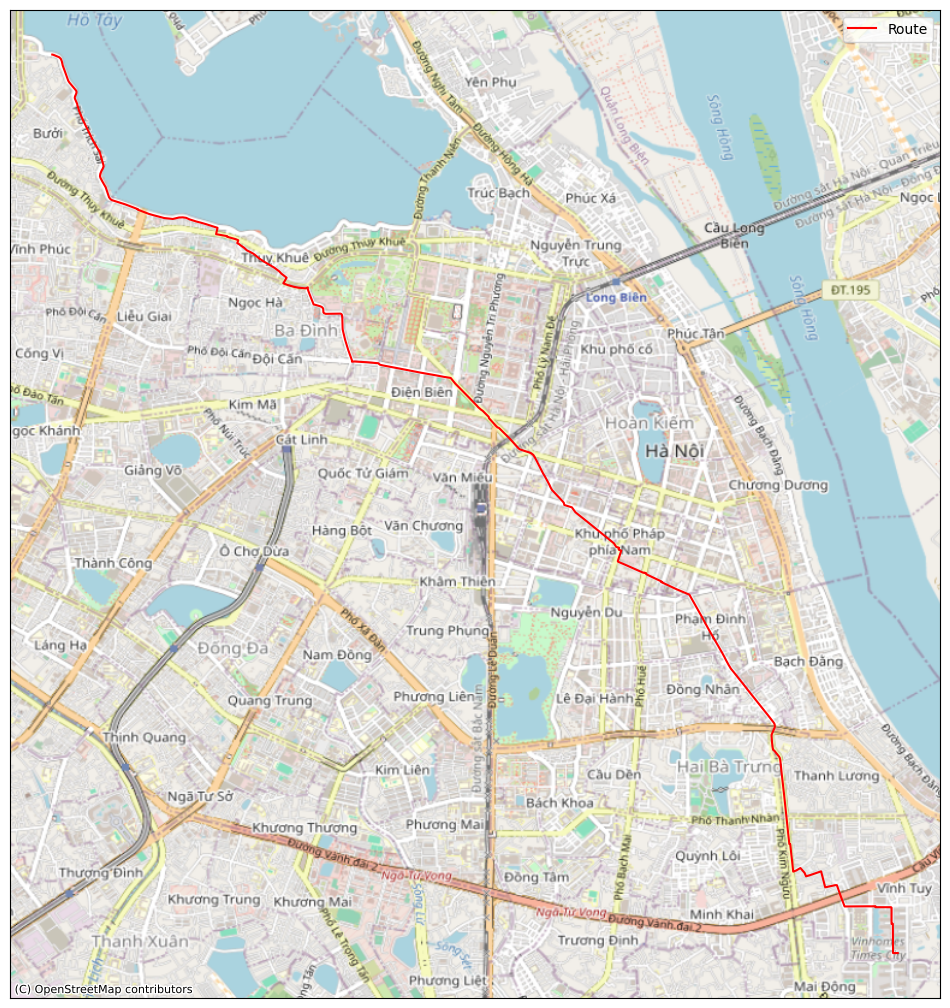

In [33]:
start = (20.993686966853396, 105.86939936393794)
stop = (21.07384862345838, 105.8152932930425)

make_route(start, stop, '../routes/West Lake - Shortest Route.gpx')